In [ ]:
#######Code for Optimization of Classifiers#######

#Loads in all required dependencies 

%matplotlib inline
import numpy as np
import pandas as pd
import umap
import warnings
from pathlib import Path
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import os
import time


#ignores warnings that print during optimization (some combinations of settings aren't allowed so it will print the warning and skip to next combo)
warnings.simplefilter('ignore')


working_directory = Path(os.getcwd())
print(working_directory)
path_data = working_directory / "classification_results_umap_together_Day1Efficiency.csv"
full_data = pd.read_csv(path_data, header=0) #reads in data for Efficiency classification
F1 = full_data[full_data.columns[0:14]] #this subselects columns 1-13 into a new dataframe so just the numeric data will be fed in (from FADA1 to Redox Ratio)


#Replaces string class identifiers to binary - for Efficiency Classifier
replace_map = {'EFFICIENCY': {'Low':0, 'High':1}}
full_data.replace(replace_map, inplace=True)



#Assign independent variables (X: OMI variables) and predictor variable (y: class labels)
X = full_data[full_data.columns[1:14]]

y = full_data[full_data.columns[19]] #class labels by Efficiency (Low - 0, High - 1)

del full_data #clears fulldata frame 


#next chunk of code gets the data ready for standardization and then standardizes it - this is just to make sure one variable doesn't have undue influrnce on the umap simply because it has higher values

#Determines scaling factors to make data range 0 - 1 (min value assigned 0, max value assigned 1)
std_scale = preprocessing.MinMaxScaler().fit(F1[['FA1',
'FA2', 'FP', 'FT1',
'FT2', 'FTM', 'NA1',
'NA2', 'NP', 'NT1',
'NT2', 'NTM','RR']])

#Transforms the numeric data with the scaling factors determined above
df_std = std_scale.transform(F1[['FA1',
'FA2', 'FP', 'FT1',
'FT2', 'FTM', 'NA1',
'NA2', 'NP', 'NT1',
'NT2', 'NTM','RR']])




#Separates standardized data into 80% training, 20% test data 
X_train, X_test, y_train, y_test = train_test_split(
   df_std,y, test_size = 0.2, random_state = 42
    )


## Support Vector Machine Classification 
print('SVM Classification')


#Initializes a linear support vector machine classifier
svc = SVC(kernel = "linear", probability = True)

#Provides the bounds of classifier parameters to iterate through to optimize classifier performance
params_grid = {'C': [10 ** k for k in range(-3, 4)]}


#Exhaustively searches over specific parameter range  for  best estimator for classification on training data with default 5-fold cross validation
clfSV = GridSearchCV(svc, params_grid)
clfSV.fit(X_train, y_train)


print("Best parameters set found on development set:")
print(clfSV.best_params_)
      
      
print(
    "Accuracy on the test set with raw data: {:.5f}".format(clfSV.score(X_test, y_test))
)

#Determines decision function from classification (how far away each point is from hyperplane separating classes and to which side of hyperplane [class] the point belongs)       
SVraw_decision_scores = clfSV.decision_function(X_test)
#Determines false positive rate and true positive rate for plotting ROC curves
fprSV, tprSV, thresSV = roc_curve(y_test, SVraw_decision_scores, pos_label = 1)





#Random Forest Classification 
print('Random Forest Classification') 

# Determining best parameters for Random Forest Classication 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


      

#Initializes a linear support vector machine classifier      
rfc = RandomForestClassifier()


#Exhaustively searches over specific parameter range  for  best estimator for classification on training data with 3-fold cross validation      
rf_random = RandomizedSearchCV(estimator=rfc, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42)
rf_random.fit(X_train, y_train)

      
print("Best parameters set found on development set:")
print(rf_random.best_params_)
print(
    "Accuracy on the test set with raw data: {:.5f}".format(rf_random.score(X_test, y_test))
)


#Determines likelihood of belonging to each class       
rf_raw_decision_scores = rf_random.predict_proba(X_test)
#Determines false positive rate and true positive rate for plotting ROC curves
fprRF, tprRF, thresRF = roc_curve(y_test, rf_raw_decision_scores[:,1])



#Logistic Regression Classification 
print("Logistic Regression Classification")

#Initializes a logistic regression classifier  
lrc = LogisticRegression()

#Provides the bounds of classifier parameters to iterate through to optimize classifier performance
param_lrc = {'penalty': ['l2'],
              'C': np.logspace(-4,4,20),
              'solver':['newton-cg', 'lbfgs','sag','saga']}

      
#Exhaustively searches over specific parameter range  for  best estimator for classification on training data with default 5-fold cross validation      
clfLR = GridSearchCV(estimator = LogisticRegression(), param_grid = param_lrc, cv = 3)
clfLR.fit(X_train, y_train)
      
      
print(clfLR.best_params_)
print(
    "Accuracy on the test set with raw data: {:.5f}".format(clfLR.score(X_test, y_test))
)

#Determines decision function from classification (how far away each point is from hyperplane separating classes and to which side of hyperplane [class] the point belongs)      
lr_raw_decision_scores = clfLR.decision_function(X_test)
#Determines false positive rate and true positive rate for plotting ROC curves
fprLR, tprLR, thresLR = roc_curve(y_test, lr_raw_decision_scores, pos_label = 1)




#Generates roc curve to compare performance of all 3 classifiers based on their optimized parameters
plt.plot(fprSV, tprSV, "r", label='Linear SVM, AUC:{:.5f}'.format(roc_auc_score(y_test, SVraw_decision_scores)))
plt.plot(fprRF, tprRF, "g", label='Random Forest, AUC:{:.5f}'.format(roc_auc_score(y_test, rf_raw_decision_scores[:,1])))
plt.plot(fprLR, tprLR, "y", label='Logistic Regression, AUC:{:.5f}'.format(roc_auc_score(y_test, lr_raw_decision_scores)))
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.savefig('ROC curve by day_ALL.tif') #saves tif of ROC curves
plt.show()

del F1      
      
 

C:\Users\Tiffany\Documents\Code files and sample data
SVM Classification
Best parameters set found on development set:
{'C': 1000}
Accuracy on the test set with raw data: 0.93227
Random Forest Classification


SVM Classification


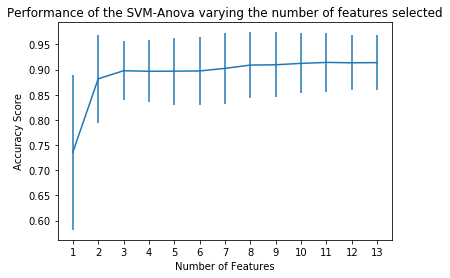

SVM Accuracy:
0.7356278018572652 0.8815550187193989 0.8976033742408287 0.8965059141331523 0.8967394274288815 0.897167515966616 0.9022682320526761 0.9088226092641528 0.9094110752386182 0.912201444212398 0.9140869859544749 0.9133405242491457 0.913693303065176
RF Classification
RF Accuracy on the test set with raw data: 0.96938


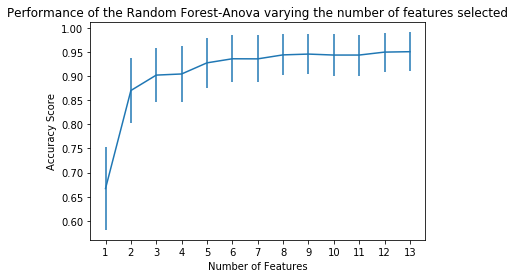

RF Accuracy:
0.6671269590879731 0.8699682077488341 0.9018452771851779 0.9042023778422961 0.9272085259251017 0.9356530926646088 0.9354559508734515 0.9437062890576482 0.9453548951933458 0.9433513132156273 0.9433510820730071 0.9494354494770962 0.9502990721119957
LR Classification
LR Accuracy on the test set with raw data: 0.934


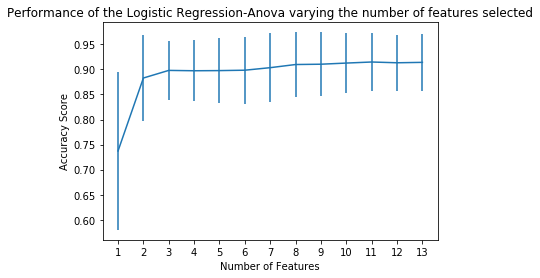

LR Accuracy:
0.7371967975260536 0.8828898998002749 0.8980752568154546 0.8973703231758698 0.8976832388229983 0.898464707468947 0.9035261385694741 0.9098054050657979 0.9104332484610559 0.9127124266841574 0.9148333316527355 0.9133013316171684 0.9141251605730207


In [12]:
#######Code for Classifier Results #######


#Loads in all required dependencies 

%matplotlib inline
import numpy as np
import pandas as pd
import umap
import warnings
from pathlib import Path
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

import os
import time


#ignores warnings that print during optimization (some combinations of settings aren't allowed so it will print the warning and skip to next combo)
warnings.simplefilter('ignore')



#
working_directory = Path(os.getcwd())
print(working_directory)
path_data = working_directory / "classification_results_umap_together_Day1Efficiency.csv"
full_data = pd.read_csv(path_data, header=0) #reads in data for Efficiency classification
F1 = full_data[full_data.columns[0:14]] #this subselects columns 1-13 into a new dataframe so just the numeric data will be fed in (from FADA1 to Redox Ratio)


#Replaces string class identifiers to binary - for Efficiency Classifier
replace_map = {'EFFICIENCY': {'Low':0, 'High':1}}
full_data.replace(replace_map, inplace=True)


#Assign independent variables (X: OMI variables) and predictor variable (y: class labels)
X = full_data[full_data.columns[1:14]]

y = full_data[full_data.columns[19]] #class labels by Efficiency (Low - 0, High - 1)


del full_data #clears fulldata frame


#next chunk of code gets the data ready for standardization and then standardizes it - this is just to make sure one variable doesn't have undue influrnce on the umap simply because it has higher values

#Determines scaling factors to make data range 0 - 1 (min value assigned 0, max value assigned 1)
std_scale = preprocessing.MinMaxScaler().fit(F1[['FA1',
'FA2', 'FP', 'FT1',
'FT2', 'FTM', 'NA1',
'NA2', 'NP', 'NT1',
'NT2', 'NTM','RR']])

#Transforms the numeric data with the scaling factors determined above
df_std = std_scale.transform(F1[['FA1',
'FA2', 'FP', 'FT1',
'FT2', 'FTM', 'NA1',
'NA2', 'NP', 'NT1',
'NT2', 'NTM','RR']])



df_std_X = df_std[0:25741] #Run with Efficiency classification (used for per variable accuracy graph)

#Separates standardized data into 80% training, 20% test data 
X_trainmat, X_testmat, y_train, y_test = train_test_split(
   df_std,y, test_size = 0.2, random_state = 42
    )

#Converts training and test data sets into Dataframes (Necessary for subselections of variables for ROC curves)
X_train = pd.DataFrame(X_trainmat)
X_test = pd.DataFrame(X_testmat)




      
##Optimized Parameters for Efficiency Classifier##      
    #SVM parameters {'C': 1000}
    #Random Forest parameters {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
    #Logistic Regression parameters {'C': 1438.44988828766, 'penalty': 'l2', 'solver': 'newton-cg'}      

##Optimized Parameters for Day Classifier## 
    #SVM Parameters {'C': 1000}
    #Random Forest parameters Random Forest Classification {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
    #Logistic Regression parametersLogistic Regression Classification {'C': 10000.0, 'penalty': 'l2', 'solver': 'newton-cg'}

##Change the parameters of the below code to depending on what classifier you are running



## Support Vector Machine Classification 
print('SVM Classification')


#Initializes and trains a linear support vector machine classifier
svc = SVC(C = 1000, kernel = "linear",  probability = True, random_state=42)
svc.fit(X_train, y_train)

print(
    "SVM Accuracy on the test set with raw data: {:.5f}".format(svc.score(X_test, y_test))
)


#Determines decision function from classification (how far away each point is from hyperplane separating classes and to which side of hyperplane [class] the point belongs)       
SVM_raw_decision_scores = svc.decision_function(X_test)
#Determines false positive rate and true positive rate for plotting ROC curves
fprSVM, tprSVM, thresSVM = roc_curve(y_test, SVM_raw_decision_scores, pos_label = 1)





#Relationship between SVM Classification accuracy and features used for classification

#Generates a pipeline to iterate number of features used for SVM classification 
clfSVM = Pipeline([('anova', SelectKBest(chi2)), #Selects the best k features based on Chi-square test for feature selection
                     ('svc', svc)])

score_meansSVM = list()
score_stdsSVM = list()
features = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13) #Number of possible features (OMI variables)


#Iterates through number of features selected to calculate respective accuracy scores
for feature in features:
    clfSVM.set_params(anova__k=feature) #Sets the number of best features to be selected
    this_scoresSVM = cross_val_score(clfSVM,df_std_X, y, cv = 15) #Estimates the Efficiency classification accuracy score based on best features used, with 15-fold cross validation 
    score_meansSVM.append(this_scoresSVM.mean()) #Calculates mean accuracy scores
    score_stdsSVM.append(this_scoresSVM.std()) #Calculates standard deviation of accuracy scores

    
#Plot graph of classification accuracy as aa function of number of features    
plt.errorbar(features, score_meansSVM, np.array(score_stdsSVM))#
plt.title(
    'Performance of the SVM-Anova varying the number of features selected')
plt.xticks(np.linspace(1, 13, 13, endpoint=True))
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig('Accuracy_SVM_byvar_Day1_efficiency.eps') #Save .eps file of graph (can change to tif or other file type)
plt.show()


print(
    "SVM Accuracy:"
)

print(*score_meansSVM)




#Random Forest Classification 
print('RF Classification')
 
#Initializes and trains a Random Forest classifier
rfc = RandomForestClassifier(n_estimators = 800,
 min_samples_split = 5,
 min_samples_leaf= 1,
 max_features = 'sqrt',
 max_depth = 70,
 bootstrap = False,
 random_state = 42)

rfc.fit(X_train, y_train)


print(
    "RF Accuracy on the test set with raw data: {:.5f}".format(rfc.score(X_test, y_test))
)

#Determines likelihood of belonging to each class 
rf_raw_decision_scores1 = rfc.predict_proba(X_test)
#Determines false positive rate and true positive rate for plotting ROC curves
fprRF, tprRF, thresRF = roc_curve(y_test, rf_raw_decision_scores1[:,1])




#Relationship between RF Classification accuracy and features used for classification

#Generates a pipeline to iterate number of features used for RF classification 
clfRF = Pipeline([('anova', SelectKBest(chi2)),
                     ('rfc', rfc)])

score_meansRF = list()
score_stdsRF = list()
features = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)



#Iterates through number of features selected to calculate respective accuracy scores
for feature in features:
    clfRF.set_params(anova__k=feature) #Sets the number of best features to be selected
    this_scoresRF = cross_val_score(clfRF,df_std_X, y, cv = 15) #Estimates the Efficiency classification accuracy score based on best features used, with 15-fold cross validation
    score_meansRF.append(this_scoresRF.mean()) #Calculates mean accuracy scores
    score_stdsRF.append(this_scoresRF.std())#Calculates standard deviation of accuracy scores

    
    
#Plot graph of classification accuracy as a function of number of features
plt.errorbar(features, score_meansRF, np.array(score_stdsRF))
plt.title(
    'Performance of the Random Forest-Anova varying the number of features selected')
plt.xticks(np.linspace(1, 13, 13, endpoint=True))
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig('Accuracy_RF_byvar_Day1_efficiency.eps') #Save .eps file of graph (can change to tif or other file
plt.show()

print(
    "RF Accuracy:"
)

print(*score_meansRF)


#Generate ROC curves for just SVM and RF together
plt.plot(fprSVM, tprSVM, "r", label='Linear SVM, AUC:{:.4f}'.format(roc_auc_score(y_test, SVM_raw_decision_scores)))
plt.plot(fprRF, tprRF, "g", label='Random Forest, AUC:{:.4f}'.format(roc_auc_score(y_test, rf_raw_decision_scores1[:,1])))
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.savefig('LR_RF_ROCcurve_Day1_efficiency.eps') #Save .eps file of graph (can change to tif or other file
plt.show()




#Logisitic Regression Classification with all variables
print('LR Classification')


#Initializes and trains a Random Forest classifier
lrc_13 = LogisticRegression(C= 1438.44988828766, penalty = 'l2', solver = 'newton-cg', random_state=42)
lrc_13.fit(X_train, y_train)

print(
    "LR Accuracy on the test set with raw data: {:.3f}".format(lrc_13.score(X_test, y_test))
)

#Determines decision function from classification
lr13_raw_decision_scores = lrc_13.decision_function(X_test)
#Determines false positive rate and true positive rate for plotting ROC curves
fprLR13, tprLR13, thresLR13 = roc_curve(y_test, lr13_raw_decision_scores, pos_label = 1)



#Relationship between LR Classification accuracy and features used for classification

#Generates a pipeline to iterate number of features used for LR classification 
lrc_clf = Pipeline([('anova', SelectKBest(chi2)),
                ('lrc', lrc_13)])

lrc_score_means = list()
lrc_score_stds = list()
features = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)


#Iterates through number of features selected to calculate respective accuracy scores
for feature in features:
    lrc_clf.set_params(anova__k=feature) #Sets the number of best features to be selected
    lrc_this_scores = cross_val_score(lrc_clf,df_std_X, y, cv = 15) #Estimates the Efficiency classification accuracy score based on best features used, with 15-fold cross validatio
    lrc_score_means.append(lrc_this_scores.mean()) #Calculates mean accuracy scores
    lrc_score_stds.append(lrc_this_scores.std()) #Calculates standard deviation of accuracy scores


    
#Plot graph of classification accuracy as a function of number of features    
plt.errorbar(features, lrc_score_means, np.array(lrc_score_stds))
plt.title(
    'Performance of the Logistic Regression-Anova varying the number of features selected')
plt.xticks(np.linspace(1, 13, 13, endpoint=True))
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.savefig('Accuracy_LR_byvar_Day1_efficiency.eps') #Save .eps file of graph (can change to tif or other file
plt.show()
plt.show()

print(
    "LR Accuracy:"
)

print(*lrc_score_means)



#Plot LR Feature weights based on classification with all 13 variables
features_names = ['FA1','FA2','FP', 'FT1','FT2', 'FTM', 'NA1','NA2','NP','NT1', 'NT2', 'NTM', 'RR']


ax = pd.Series(abs(lrc_13.coef_[0]), index=features_names).nlargest(13).plot(kind='barh') #Takes coefficients of features from LR classification and plots them in order from largest to smalleste

ax.set_xlabel("Logistic Regression Feature weights")

# Set the y-axis label
ax.set_ylabel("Features")
fig = ax.get_figure()
fig.savefig('Feature_weights_LR_Day1_efficiency.eps') #Save .eps file of graph




#Logistic Regression Classification with most important variable (NADH tm) 


#Truncate data to NADH tm and FAD tm 
NADHtrain = np.array(X_train[X_train.columns[11]])
NADHtest = np.array(X_test[X_test.columns[11]])

#Train LR Classifier with just NADH tm and FAD tm
lrcNTM = LogisticRegression(C= 10000, penalty = 'l2', solver = 'newton-cg', random_state=42)
lrcNTM.fit(NADHtrain.reshape(-1,1), y_train)

print(
    "Accuracy on the NTM test set with raw data: {:.3f}".format(lrcNTM.score(NADHtest.reshape(-1,1), y_test))
)


#Generate ROC Curve parameters
lr_NTM_raw_decision_scores = lrcNTM.decision_function(NADHtest.reshape(-1,1))
fprNTM, tprNTM, thresNTM = roc_curve(y_test, lr_NTM_raw_decision_scores, pos_label = 1)

#Logistic Regression Classification with NADH tm and FAD tm

#Truncate data to NADH tm and FAD tm 
Xfirst2 = np.array(X_train[X_train.columns[5]])
Xsecond2 = np.array(X_train[X_train.columns[11]])
XfirstT2 = np.array(X_test[X_test.columns[5]])
XsecondT2 = np.array(X_test[X_test.columns[11]])

#Recombine data
X_NTMFTM = np.vstack((Xfirst2,Xsecond2))
X_test_NTMFTM = np.vstack((XfirstT2,XsecondT2))

#Train LR Classifier with just NADH tm and FAD tm
lrcNTMFTMtest = LogisticRegression(C= 10000, penalty = 'l2', solver = 'newton-cg', random_state=42)
lrcNTMFTMtest.fit(np.transpose(X_NTMFTM),y_train)

print(
    "Accuracy on the NTM+FTM test set with raw data: {:.3f}".format(lrcNTMFTMtest.score(np.transpose(X_test_NTMFTM), y_test))
)

#Generate ROC Curve parameters
lrNTMFTM_raw_decision_scores = lrcNTMFTMtest.decision_function(np.transpose(X_test_NTMFTM))
fprNTMFTM, tprNTMFTM, thresNTMFTM = roc_curve(y_test, lrNTMFTM_raw_decision_scores, pos_label = 1)



#Logistic Regression Classification with just FAD lifetimes 

#Truncate data to FAD lifetimes 
Xfirst = X_train[X_train.columns[0:2]] #(FAD A1 and A2)
Xsecond = X_train[X_train.columns[3:6]] #(FAD T1, T2, and TM)
XfirstT = X_test[X_test.columns[0:2]] #(FAD A1 and A2)
XsecondT = X_test[X_test.columns[3:6]] #(FAD T1, T2, and TM)

#Recombine data
X_FAD = np.concatenate((Xfirst,Xsecond),axis=1)
X_test_FAD = np.concatenate((XfirstT,XsecondT),axis=1)


#Train LR Classifier with just FAD lifetimes
lrc_FAD = LogisticRegression(C= 10000, penalty = 'l2', solver = 'newton-cg', random_state=42)
lrc_FAD.fit(X_FAD, y_train)


#Generate ROC Curve parameters
lrFAD_raw_decision_scores = lrc_FAD.decision_function(X_test_FAD)
fprLR_FAD, tprLR_FAD, thresLRC_FAD = roc_curve(y_test, lrFAD_raw_decision_scores, pos_label = 1)

print(
    "Accuracy on the FAD TM test set with raw data: {:.3f}".format(lrc_FAD.score(X_test_FAD, y_test))
)

#Logistic Regressoin Classification with just NADH lifetimes 

#Truncate data to NADH lifetimes 
Xfirst = X_train[X_train.columns[6:8]] #(NADH A1 and A2)
Xsecond = X_train[X_train.columns[9:12]] #(NADH T1, T2, and TM)
XfirstT = X_test[X_test.columns[6:8]] #(NADH A1 and A2)
XsecondT = X_test[X_test.columns[9:12]] #(NADH T1, T2, and TM)


#Recombine data
X_NADH = np.concatenate((Xfirst,Xsecond),axis=1)
X_test_NADH = np.concatenate((XfirstT,XsecondT),axis=1)

#Train LR Classifier with just NADH lifetimes 
lrc_NADH = LogisticRegression(C= 10000, penalty = 'l2', solver = 'newton-cg', random_state=42)
lrc_NADH.fit(X_NADH, y_train)

#Generate ROC Curve parameters
lrNADH_raw_decision_scores = lrc_NADH.decision_function(X_test_NADH)
fprLR_NADH, tprLR_NADH, thresLRC_NADH = roc_curve(y_test, lrNADH_raw_decision_scores, pos_label = 1)

print(
    "Accuracy on the NADH TM test set with raw data: {:.3f}".format(lrc_NADH.score(X_test_NADH, y_test))
)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Text(0.5, 1, 'ROC curve')

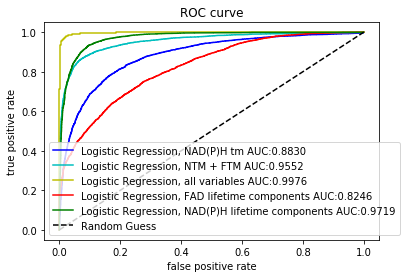

In [20]:
####ROC Curve plots with all Logistic Regression combinations#####

plt.plot(fprNTM, tprNTM, "b", label='Logistic Regression, NAD(P)H tm AUC:{:.4f}'.format(roc_auc_score(y_test, lr_NTM_raw_decision_scores)))
plt.plot(fprNTMFTM, tprNTMFTM, "c", label='Logistic Regression, NTM + FTM AUC:{:.4f}'.format(roc_auc_score(y_test, lrNTMFTM_raw_decision_scores)))
plt.plot(fprLR13, tprLR13, "y", label='Logistic Regression, all variables AUC:{:.4f}'.format(roc_auc_score(y_test, lr13_raw_decision_scores)))
plt.plot(fprLR_FAD, tprLR_FAD, "r", label='Logistic Regression, FAD lifetime components AUC:{:.4f}'.format(roc_auc_score(y_test, lrFAD_raw_decision_scores)))
plt.plot(fprLR_NADH, tprLR_NADH, "g", label='Logistic Regression, NAD(P)H lifetime components AUC:{:.4f}'.format(roc_auc_score(y_test, lrNADH_raw_decision_scores)))
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.savefig('LR ROC Day1 efficiency.eps')
plt.title("ROC curve")

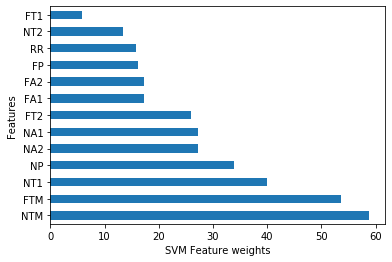

In [21]:
#####Feature weight plots for SVM Classification#####

features_names = ['FA1','FA2','FP', 'FT1','FT2', 'FTM', 'NA1','NA2','NP','NT1', 'NT2', 'NTM', 'RR']

#Plot SVM Feature weights based on classification with all 13 variables
ax = pd.Series(abs(svc.coef_[0]), index=features_names).nlargest(13).plot(kind='barh')


# Set the axes labels
ax.set_xlabel("SVM Feature weights")
ax.set_ylabel("Features")

fig = ax.get_figure()
fig.savefig('Feature_weights_SVC_Day1_efficiency.eps')

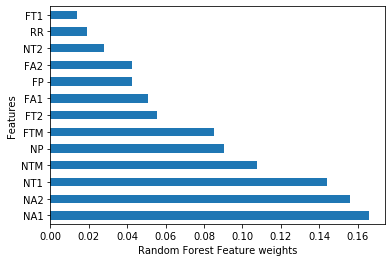

In [22]:
#####Feature weight plots for RF Classification#####

#Plot RF Feature weights based on classification with all 13 variables
features_names = ['FA1','FA2', 'FP', 'FT1','FT2', 'FTM', 'NA1','NA2', 'NP', 'NT1', 'NT2', 'NTM','RR']
ax = pd.Series(abs(rfc.feature_importances_), index=features_names).nlargest(13).plot(kind='barh') 


# Set the axes labels
ax.set_xlabel("Random Forest Feature weights")
ax.set_ylabel("Features")


fig = ax.get_figure()
fig.savefig('Feature_weights_RF_Day1_efficiency.eps')